# Trainable Quantum Convolution

**Authors**
  * Denny Mattern (denny.mattern@fokus.fraunhofer.de)
  * Darya Martyniuk (darya.martyniuk@fokus.fraunhofer.de)
  * Fabian Bergmann (fabian.bergmann@fokus.fraunhofer.de)
  * Henri Willems (henri.willems@fokus.fraunhofer.de)


**Affiliation**

Data Analytics Center at Fraunhofer Institute for Open Communication Systems (Fraunhofer FOKUS) [1]. This demo results from our research as part of the PlanQK consortium [2].


**Abstract**

We implement a trainable version of Quanvolutional Neural Networks [3] using parametrized RandomCircuits. Parameters are optimized using standard gradient descent. Our code is based on the "Quanvolutional Neural Networks"-Demo of Andrea Mari [4].

We find that due to the randomized circuits training process is challenging and might take for some randomly generated circuits quite long, while other random circuits seem to be more suitable. For more stable results one might want to use hand crafted circuits instead of randomly generated ones. Otherwise one can use static seeds for the random circuit in order to get reproducable results.


**Further Research Questions**


1. What is the impact of the quantum layer to the result?
2. Is our hybrid quantum-classical neural net learning because of the trainable quanvolution or despite the quantum layer? I.e. is the quantum layer learning anything useful which helps the following layer to better classify the digits? Or is the dense layer "strong enough" to perform a classification despite the quantum circuit before?
3. If the quantum circuit is useful, what kinds of circuit architectures perform best?


[1] https://www.fokus.fraunhofer.de and https://www.data-analytics-center.org.

[2] https://www.planqk.de.

[3] Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan Cook, "Quanvolutional Neural Networks: Powering Image Recognition with Quantum Circuits", 2019, arxiv:1904.04767.

[4] https://pennylane.ai/qml/demos/tutorial_quanvolution.html.

In [2]:
pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 1.2 MB/s eta 0:00:00a 0:00:010m
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
from torch import nn

import torchvision

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [13]:
class QonvLayer(nn.Module):
    def __init__(self, stride=2, device="default.qubit", wires=4, circuit_layers=4, n_rotations=8, out_channels=4, seed=None):
        super(QonvLayer, self).__init__()
        
        # init device
        self.wires = wires
        self.dev = qml.device(device, wires=self.wires)
        
        self.stride = stride
        self.out_channels = min(out_channels, wires)
        
        if seed is None:
            seed = np.random.randint(low=0, high=10e6)
            
        print("Initializing Circuit with random seed", seed)
        
        # random circuits
        @qml.qnode(device=self.dev, interface="torch")
        def circuit(inputs, weights):
            n_inputs=4
            # Encoding of 4 classical input values
            for j in range(n_inputs):
                qml.RY(inputs[j], wires=j)
            # Random quantum circuit
            RandomLayers(weights, wires=list(range(self.wires)), seed=seed)
            
            # Measurement producing 4 classical output values
            return [qml.expval(qml.PauliZ(j)) for j in range(self.out_channels)]
        
        weight_shapes = {"weights": [circuit_layers, n_rotations]}
        self.circuit = qml.qnn.TorchLayer(circuit, weight_shapes=weight_shapes)
    
    
    def draw(self):
        # build circuit by sending dummy data through it
        _ = self.circuit(inputs=torch.from_numpy(np.zeros(4)))
        print(self.circuit.qnode.draw())
        self.circuit.zero_grad()
        
    
    def forward(self, img):
        bs, h, w, ch = img.size()
        if ch > 1:
            img = img.mean(axis=-1).reshape(bs, h, w, 1)
                        
        kernel_size = 2        
        h_out = (h-kernel_size) // self.stride + 1
        w_out = (w-kernel_size) // self.stride + 1
        
        
        out = torch.zeros((bs, h_out, w_out, self.out_channels))
        
        # Loop over the coordinates of the top-left pixel of 2X2 squares
        for b in range(bs):
            for j in range(0, h_out, self.stride):
                for k in range(0, w_out, self.stride):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    q_results = self.circuit(
                        inputs=torch.Tensor([
                            img[b, j, k, 0],
                            img[b, j, k + 1, 0],
                            img[b, j + 1, k, 0],
                            img[b, j + 1, k + 1, 0]
                        ])
                    )
                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    for c in range(self.out_channels):
                        out[b, j // kernel_size, k // kernel_size, c] = q_results[c]
                        
                 
        return out

Initializing Circuit with random seed 7632281


torch.Size([1, 14, 14, 4])

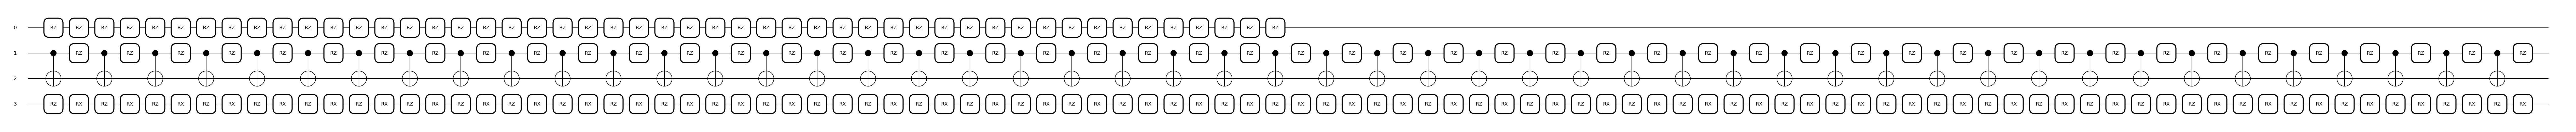

In [14]:
# Test QonvLayer

qonv = QonvLayer(circuit_layers=1, n_rotations=4, out_channels=4, stride=2)
x = torch.rand(size=(1,28,28,1)).cuda()
qml.draw_mpl(qonv)(x)

# Check OonvLayer Output shape
qonv(x).shape

In [15]:
def transform(x):
    x = np.array(x)
    x = x/255.0
    
    return torch.from_numpy(x).float()

# Model training

In [36]:
def train(model, train_loader, epochs=50):
    print("Starting Training for {} epochs".format(epochs))

    model.train()

    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()
    
    losses = np.array([])
    accs = np.array([])

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):

            # prepare inputs and labels
            x = x.view(-1, 28, 28, 1)
            y = y.long()

            # reset optimizer
            optimizer.zero_grad()

            # engage
            y_pred = model(x).to(torch.device('cpu'))

            # error, gradients and optimization
            loss = criterion(y_pred, y)  
            loss.backward()
            optimizer.step()

            # output
            # acc = accuracy_score(y, y_pred.argmax(-1).numpy())
            
            # accs = np.append(accs, acc)
            losses = np.append(losses, loss.item())

            print("Epoch:", epoch, 
                  "\tStep:", i, 
                  # "\tAcc:", round(acc, 3), 
                  "\tLoss:", round(loss.item(),3),
                  "\tMean Loss:", round(float(losses[-30:].mean()), 3),
                  "\tMean Acc:", round(float(accs[-30:].mean()), 3)
                 )
            print("\nGradients Layer 0:")
            print(model[0].circuit.weights.grad)

            # if i % 5 == 0:
            #     model[0].draw()
            
            print("---------------------------------------\n")
            
            
    return model, losses, accs

In [ ]:
if __name__ == "__main__":
    
    
    # prepare dataset
    train_set = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=4)
    
    # build the model
    model = torch.nn.Sequential(
        QonvLayer(stride=2, circuit_layers=2, n_rotations=4, out_channels=4, seed=9321727),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=14*14*4, out_features=10)
    )
    
    # start training
    model, losses, accs = train(model, train_loader, epochs=1)
    
    
    # plot losses and accuracies
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
    ax1.plot(losses)
    ax1.set_title("Loss")
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss")

    ax2.plot(accs)
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Steps")
    ax2.set_ylabel("Accuracy")

Initializing Circuit with random seed 9321727
Starting Training for 1 epochs


/tmp/ipykernel_803/3394048024.py:41: RuntimeWarning: Mean of empty slice.
  "\tMean Acc:", round(float(accs[-30:].mean()), 3)


Epoch: 0 	Step: 0 	Loss: 2.249 	Mean Loss: 2.249 	Mean Acc: nan

Gradients Layer 0:
tensor([[-1.6883e-03, -4.8591e-05, -5.1413e-02, -3.1419e-03],
        [ 8.6100e-03, -2.1710e-03,  3.7435e-04,  1.3983e-10]])
---------------------------------------

Epoch: 0 	Step: 1 	Loss: 3.278 	Mean Loss: 2.763 	Mean Acc: nan

Gradients Layer 0:
tensor([[ 5.8926e-05, -4.0270e-04,  8.1301e-01,  6.9942e-05],
        [ 4.9048e-02,  1.5453e-02, -9.6934e-02, -2.7536e-10]])
---------------------------------------

Epoch: 0 	Step: 2 	Loss: 2.016 	Mean Loss: 2.514 	Mean Acc: nan

Gradients Layer 0:
tensor([[-1.2263e-03, -1.8442e-03,  3.1948e-01, -2.2362e-03],
        [ 3.0810e-02,  6.2243e-03, -2.9113e-02, -2.6628e-10]])
---------------------------------------

Epoch: 0 	Step: 3 	Loss: 3.394 	Mean Loss: 2.734 	Mean Acc: nan

Gradients Layer 0:
tensor([[-3.9929e-03, -1.3281e-02,  1.1883e+00, -7.6338e-03],
        [ 1.0549e-01,  2.1809e-02, -1.1859e-01,  6.3319e-10]])
---------------------------------------

